In [41]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
import pandas as pd
from sklearn.mixture import GaussianMixture
import os
from scipy.stats import norm, multivariate_normal, gamma, invgamma, multinomial, dirichlet, uniform, binom, invwishart
from tqdm import tqdm
import sys
from sklearn.mixture import GaussianMixture


(array([ 7.,  0.,  2.,  6., 32., 24.,  7.,  1.,  0.,  3.]),
 array([ 9.172 , 11.6827, 14.1934, 16.7041, 19.2148, 21.7255, 24.2362,
        26.7469, 29.2576, 31.7683, 34.279 ]),
 <BarContainer object of 10 artists>)

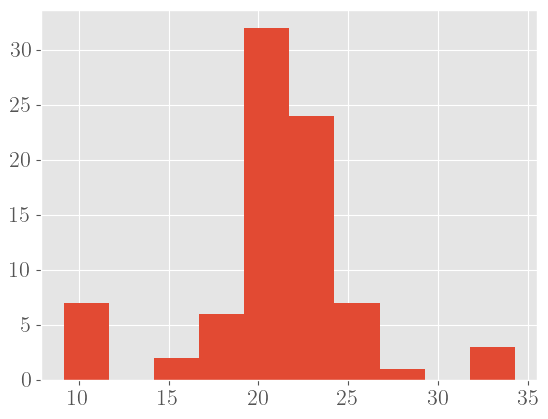

In [42]:
galaxies = pd.read_csv('../../homework_4/data/galaxies.csv')
plt.hist(galaxies['x'])

In [82]:
class GibbsSampler:
    def __init__(self, X, k=2, n_it=100, mu_0=0, sig_0=10, a=.05, b=.05, alpha=2):
        self.n = len(X)
        self.X = X
        self.k = k
        self.n_it = n_it
        self.mu_0 = mu_0
        self.sig_0 = sig_0
        self.a = a
        self.b = b
        self.alpha = alpha
        
        
        gm = GaussianMixture(n_components=k).fit(X.reshape(-1,1))
        self.weights = np.array([gm.weights_.flatten()] * n_it)
        self.means = np.array([gm.means_.flatten()] * n_it)
        self.std = np.array([gm.covariances_.flatten()] * n_it)
        
        
    def _draw_z(self, pi_ik):
        z = np.array([np.random.multinomial(n=1, pvals=pi_ik[i]) for i in range(self.n)])
        if np.all(z.sum(axis=0)) > 0:
            return z
        else:
            for k in range(self.k):
                z[k, :] = [0] * self.k
                z[k, k] = 1
            return z
            
    def _calculate_pi_ik(self, weights, means, sigmas):
        num = weights * norm.pdf(x=np.vstack([self.X] * self.k).T, loc=means, scale=sigmas)
        den = np.sum(num, axis=1)[:, None]
        return num / den
        
    
    def _update_means(self, sigmas, z):
        n_k = np.sum(z, axis=0)
        n_y_k = np.sum(z*self.X[:, None], axis=0) 
        sig_sq_k = 1/(1/self.sig_0**2 + n_k/sigmas**2)
        mus = sig_sq_k * (self.mu_0/self.sig_0**2 + n_y_k/sigmas**2)
        means = norm.rvs(loc=mus, scale=np.sqrt(sig_sq_k))
        return means
        
    
    def _update_sigmas(self, z, mus):
        n_k = np.sum(z, axis=0)
        y_bar = np.sum(z*self.X[:, None], axis=0) / n_k
        alpha = self.a + n_k/2
        beta = self.b + 0.5*(z*(self.X[:, None] - mus)**2).sum(axis=0)
        sigma_sq = 1/gamma(a=alpha, scale=1/beta).rvs()
        return np.sqrt(sigma_sq)
    
    def _update_weights(self, z):
        n_k = np.sum(z, axis=0)
        weights = dirichlet(alpha = self.alpha + n_k).rvs().flatten()
        return weights
    
    def _remove_burn(self, arr, n_burn, n_thin):
        return arr[n_burn:][::n_thin]
    
    def fit(self, n_burn=200, n_thin=2):
        for it in tqdm(range(self.n_it - 1)):
            pi_i_k = self._calculate_pi_ik(self.weights[it], self.means[it], self.std[it])
            z = self._draw_z(pi_i_k)
            #if it > 200:
            #self.means[it + 1] = self._update_means(self.means[it], z)#[idx]
            self.std[it + 1] = self._update_sigmas(z, self.means[it + 1])#[idx]
            self.weights[it + 1] = self._update_weights(z)
            
            
        if n_burn != 0 & n_thin != 0:
            self.weights = self._remove_burn(self.weights, n_burn, n_thin)
            self.std = self._remove_burn(self.std, n_burn, n_thin)
            self.means = self._remove_burn(self.means, n_burn, n_thin)
                   
            
            

In [96]:
np.random.seed(210)
n = 1000
coeffs = multinomial(p=[.3, .3, .4], n=1).rvs(size=n)
draws = norm([1, 10, 3], [1, .5, 2]).rvs(size=(n, 3))
data = draws[draws * coeffs != 0]
gs = GibbsSampler(data, k=3, n_it=1000, a=.1, b=.1, sig_0=10, alpha=4)
gs.fit()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:02<00:00, 424.87it/s]


In [97]:
def make_pdf(x, weights, means, stds):
    k = len(means)
    pdfs = weights * norm.pdf(x=np.vstack([x] * k).T, loc=means, scale=stds)
    return pdfs.sum(axis=1)

[0.4100565 0.3205785 0.269365 ] [8.65973959e-15 1.26121336e-13 7.68274333e-14]


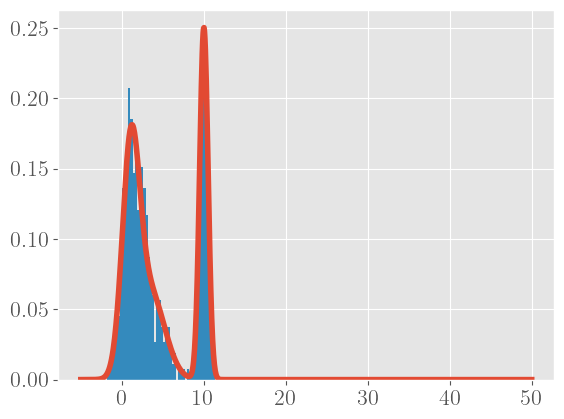

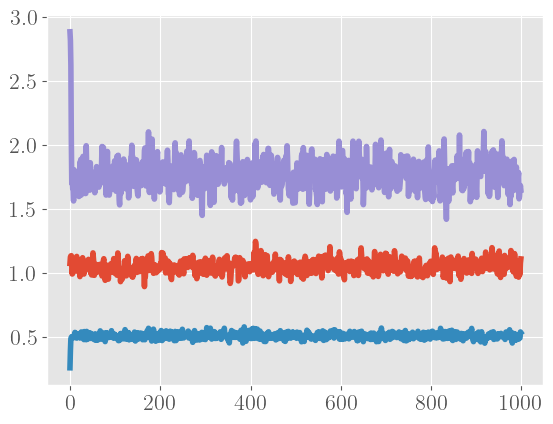

In [98]:
x = np.linspace(-5, 50, 1000)
pdf = make_pdf(x, gs.weights.mean(axis=0), gs.means.mean(axis=0), gs.std.mean(axis=0))
plt.plot(x, pdf)
plt.hist(data, density=True, bins=50);
plt.figure()
print(gs.weights.mean(axis=0), gs.means.std(axis=0))
#plt.plot(gs.weights)
plt.plot(gs.std)

In [91]:
def make_pdf(x, weights, means, stds):
    k = len(means)
    pdfs = weights * norm.pdf(x=np.vstack([x] * k).T, loc=means, scale=stds)
    #[plt.plot(x, pdfs[:, i]) for i in range(k)]
    return pdfs.sum(axis=1)

In [99]:
data = galaxies['x'].to_numpy()
gs = GibbsSampler(data, k=3, n_it=200, a=3, b=.5, alpha=.1, mu_0=np.mean(data), sig_0=10)
gs.fit(n_burn=0, n_thin=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 790.59it/s]


[21.40009883  9.71013956 33.04437731] [2.15618601 0.44018499 0.67664615] [0.87743375 0.08543154 0.03713471]


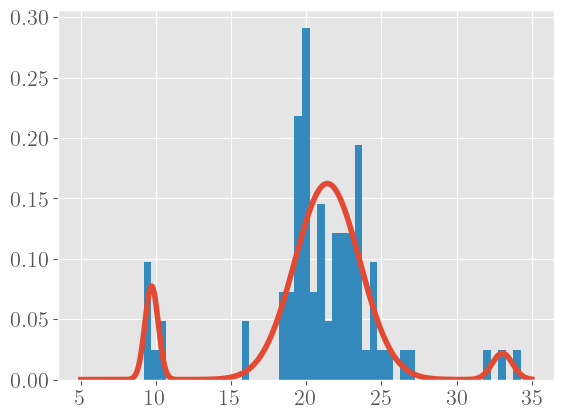

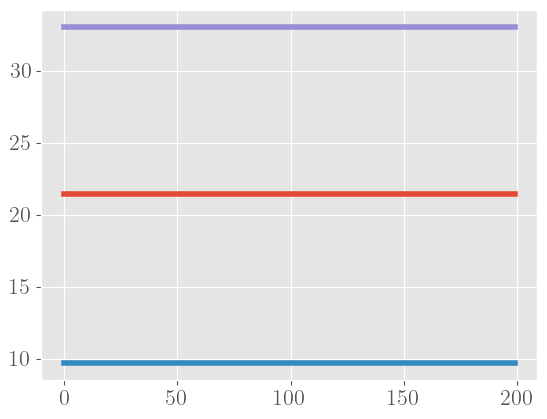

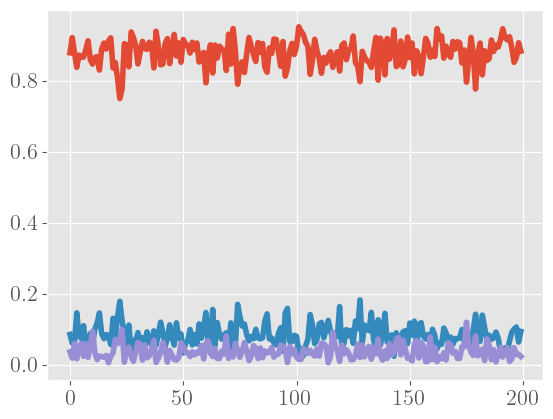

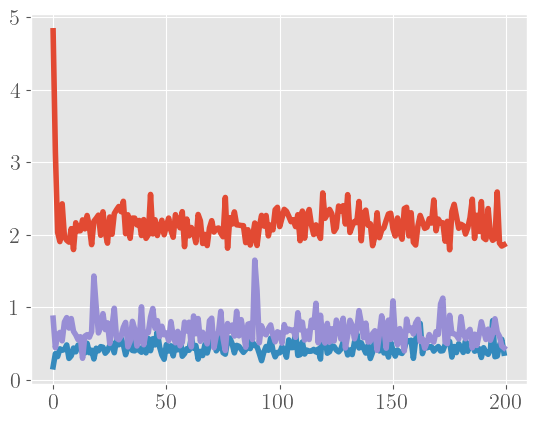

In [100]:
#plt.plot(gs.means)
x = np.linspace(5, 35, 1000)
pdf = make_pdf(x, gs.weights.mean(axis=0), gs.means.mean(axis=0), gs.std.mean(axis=0))
plt.plot(x, pdf)
plt.hist(data, density=True, bins=50)
plt.figure()

plt.plot(gs.means)
plt.figure()
plt.plot(gs.weights)
plt.figure()
plt.plot(gs.std)

print(gs.means.mean(axis=0), gs.std.mean(axis=0), gs.weights.mean(axis=0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1310.59it/s]


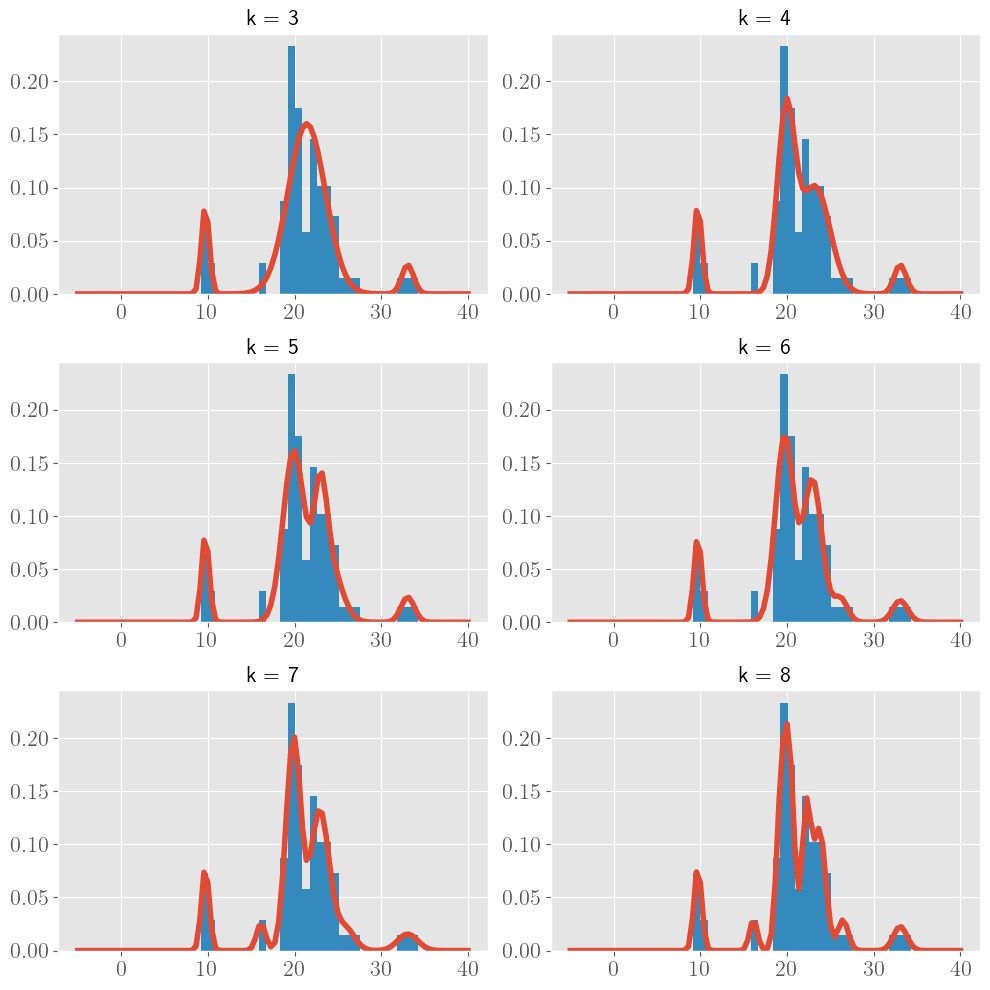

In [102]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()
ks = [3,4,5,6,7,8]
data = galaxies['x'].to_numpy()
x = np.linspace(-5, 40, 100)
for n, k in enumerate(ks):  
    gs = GibbsSampler(data, k=k, n_it=1000, a=3, b=.5, alpha=1)
    gs.fit(n_burn=0, n_thin=0)
    pdf = make_pdf(x, gs.weights.mean(axis=0), gs.means.mean(axis=0), gs.std.mean(axis=0))
    axes[n].plot(x, pdf)
    axes[n].set_title(f'k = {k}')
    axes[n].hist(data, density=True, bins=30);
    
fig.tight_layout()

In [138]:
class MvGibbsSampler:
    def __init__(self, X, k=2, n_it=1000, mu_0=0, nu_0=10, Sig_0=10, Psi_0=5, alpha=2):
        self.n, self.ndim = X.shape
        self.X = X
        self.k = k
        self.n_it = n_it
        
        
        gm = GaussianMixture(n_components=k).fit(X)
        self.weights = np.array([gm.weights_] * n_it)
        self.means = np.array([gm.means_] * n_it)
        self.covs = np.array([gm.covariances_] * n_it)

        self.mu_0 = np.ones(self.ndim) * mu_0
        self.Sig_0 = np.eye(self.ndim) * Sig_0
        self.Psi_0 = np.eye(self.ndim)  * Psi_0
        self.nu_0 = nu_0
        self.alpha = alpha
        
        
    def _draw_z(self, pi_ik):
        z = np.array([np.random.multinomial(n=1, pvals=pi_ik[i, :]) for i in range(self.n)])
        return z
            
    def _calculate_pi_ik(self, weights, means, covs):
        pi_ik = np.zeros([self.n, self.k])
        for k in range(self.k):
            pi_ik[:, k] = weights[k] * multivariate_normal.pdf(x=self.X, mean=means[k], cov=covs[k], allow_singular=True) 
        return pi_ik / np.sum(pi_ik, axis=1)[:, None]
    
    
    def _update_means(self, covs_k, z):
        means = np.zeros((self.k, self.ndim))
        for k in range(self.k):   
            inv_cov = np.linalg.inv(covs_k[k])
            cov = np.linalg.inv(np.sum(z[:, k]) * inv_cov + np.linalg.inv(self.Sig_0))
            mus = cov@(inv_cov @ np.sum(self.X * z[:, k][:, None], axis=0) + np.linalg.inv(self.Sig_0)@self.mu_0)
            means[k] = multivariate_normal(mus, cov).rvs()
        return means
        
    
    def _update_covs(self, z, mus):
        covs = np.zeros((self.k, self.ndim, self.ndim))
        nu = np.sum(z, axis=0) + self.nu_0
        for k in range(self.k):
            terms = np.array([(self.X[i, :] - mus[k]).reshape(-1, 1)@(self.X[i, :] - mus[k]).reshape(-1, 1).T * z[i, k] for i in range(self.n)])
            Psi_prime = np.sum(terms, axis=0)
            covs[k] = invwishart(nu[k], Psi_prime + self.Psi_0).rvs()
        return covs
    
    def _update_weights(self, z):
        n_k = np.sum(z, axis=0)
        weights = dirichlet(alpha = self.alpha + n_k).rvs().flatten()
        return weights
    
    def _remove_burn(self, arr, n_burn, n_thin):
        return arr[n_burn:][::n_thin]
    
    def fit(self, n_burn=500, n_thin=2):
        for it in tqdm(range(self.n_it - 1)):
            pi_i_k = self._calculate_pi_ik(self.weights[it], self.means[it], self.covs[it])
            z = self._draw_z(pi_i_k)
            self.means[it + 1] = self._update_means(self.covs[it], z)
            self.covs[it + 1] = self._update_covs(z, self.means[it + 1])
            self.weights[it + 1] = self._update_weights(z)
            
        #self.weights = self._remove_burn(self.weights, n_burn, n_thin)
       # self.covs = self._remove_burn(self.covs, n_burn, n_thin)
       # self.means = self._remove_burn(self.means, n_burn, n_thin)
        
                   
            
            

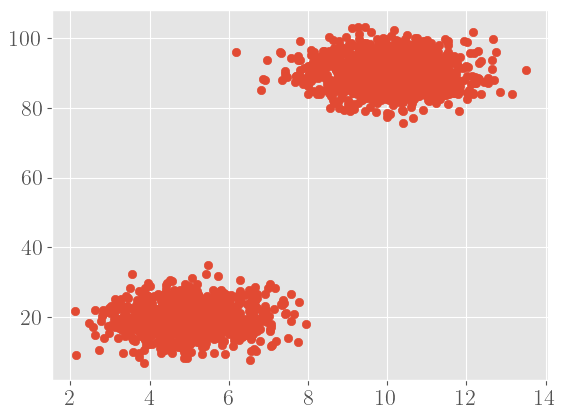

In [139]:
n = 2000
mu = [[5, 20], [10, 90]]
covs = (np.array([[1, 0], [0, 20]]), np.array([[1, 0], [0, 20]]))
weights = [.4, .6]
coeffs = multinomial(p=weights, n=1).rvs(size=n)
idx = np.argwhere(coeffs == 1)[:, 1]
draws = np.array([multivariate_normal(mu[i], covs[i], allow_singular=True).rvs() for i in idx])

plt.scatter(draws[:, 0], draws[:, 1])

In [128]:
gs = MvGibbsSampler(draws, n_it=1000, nu_0=20, Sig_0=10, Psi_0=1, k=3, alpha=1)
gs.fit()

 16%|██████████████████████████████▎                                                                                                                                                             | 161/999 [00:06<00:35, 23.85it/s]


KeyboardInterrupt: 

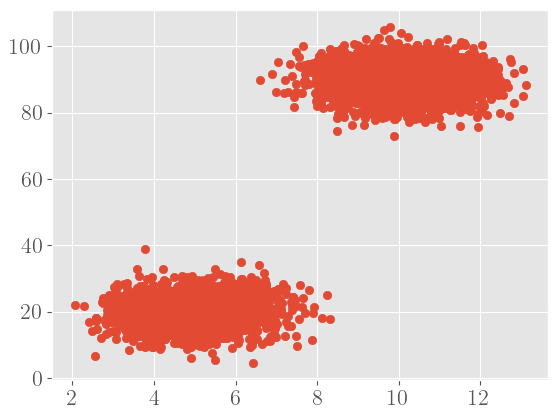

In [25]:
n = 5000
mu = gs.means.mean(axis=0)
covs = np.array(gs.covs).mean(axis=0)
weights = gs.weights.mean(axis=0)
coeffs = multinomial(p=weights, n=1).rvs(size=n)
idx = np.argwhere(coeffs == 1)[:, 1]
draws = np.array([multivariate_normal(mu[i], covs[i], allow_singular=True).rvs() for i in idx])
plt.scatter(draws[:, 0], draws[:, 1])

In [140]:
faithful = pd.read_csv('../../homework_4/data/faithful.csv')
X = faithful[['eruptions', 'waiting']].to_numpy()

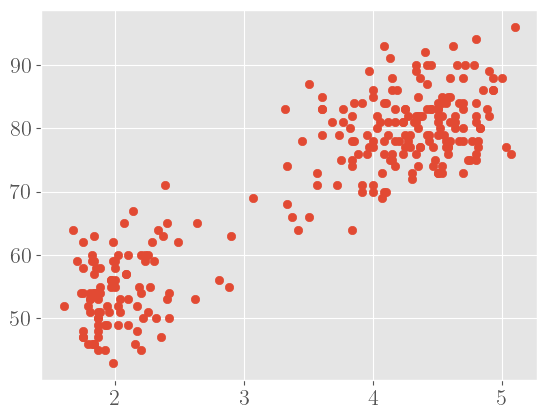

In [141]:
plt.scatter(X[:, 0], X[:, 1])

In [145]:
gs = MvGibbsSampler(X, n_it=100, nu_0=5, Sig_0=20, Psi_0=10, k=2, alpha=1)
gs.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 181.95it/s]


In [146]:
gs.means.shape

(100, 2, 2)

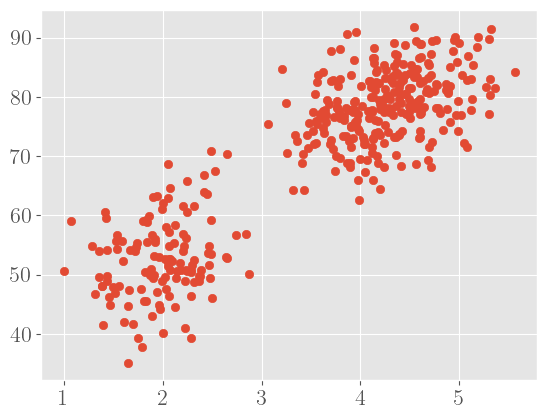

In [147]:
n = 400
mu = gs.means.mean(axis=0)
covs = np.array(gs.covs).mean(axis=0)
weights = gs.weights.mean(axis=0)
coeffs = multinomial(p=weights, n=1).rvs(size=n)
idx = np.argwhere(coeffs == 1)[:, 1]
draws = np.array([multivariate_normal(mu[i], covs[i], allow_singular=True).rvs() for i in idx])
plt.scatter(draws[:, 0], draws[:, 1])

In [40]:
m = gs.means.mean(axis=0)
m

array([[ 2.01647134, 53.47555102],
       [ 0.30729768,  4.33101546],
       [ 0.10850216,  1.29638616],
       [ 4.35319112, 81.16266944],
       [ 3.64929798, 68.53799015]])

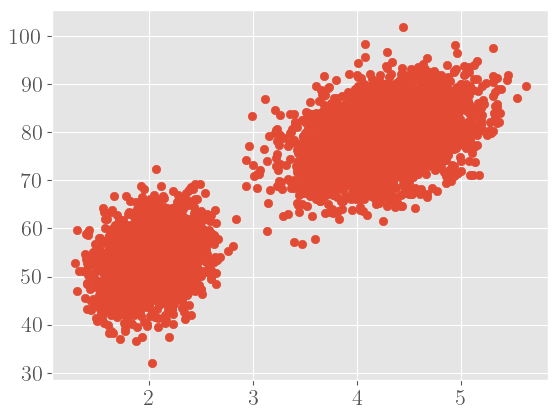

In [501]:
n = 5000
mu = gs.means.mean(axis=0)
covs = np.array(gs.covs).mean(axis=0)
weights = gs.weights.mean(axis=0)
coeffs = multinomial(p=weights, n=1).rvs(size=n)
idx = np.argwhere(coeffs == 1)[:, 1]
draws = np.array([multivariate_normal(mu[i], covs[i], allow_singular=True).rvs() for i in idx])
plt.scatter(draws[:, 0], draws[:, 1])

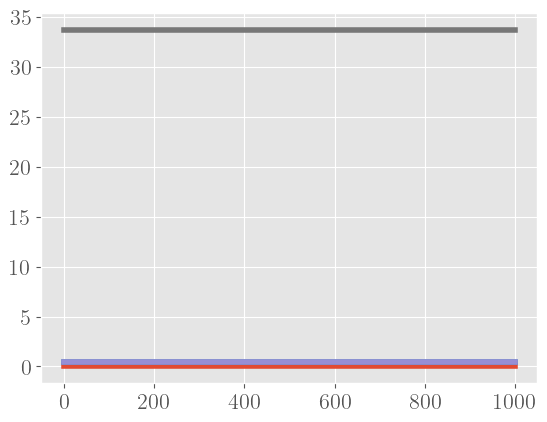

In [502]:
plt.plot(np.array(gs.covs)[:, 1, 0])
plt.plot(np.array(gs.covs)[:, 1, 1])

#plt.plot(gs.covs[:, 0, 0])

In [503]:
gs.means[0]

array([[ 4.28977944, 79.96953298],
       [ 2.03652149, 54.47986018]])

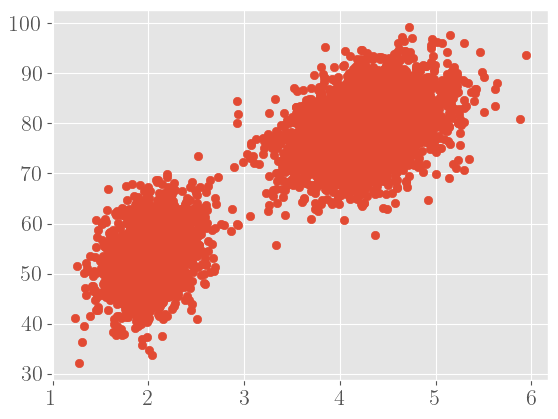

In [504]:
n = 5000
mu = gs.means.mean(axis=0)
covs = np.array(gs.covs).mean(axis=0)
weights = gs.weights.mean(axis=0)
coeffs = multinomial(p=weights, n=1).rvs(size=n)
idx = np.argwhere(coeffs == 1)[:, 1]
draws = np.array([multivariate_normal(mu[i], covs[i], allow_singular=True).rvs() for i in idx])
plt.scatter(draws[:, 0], draws[:, 1])

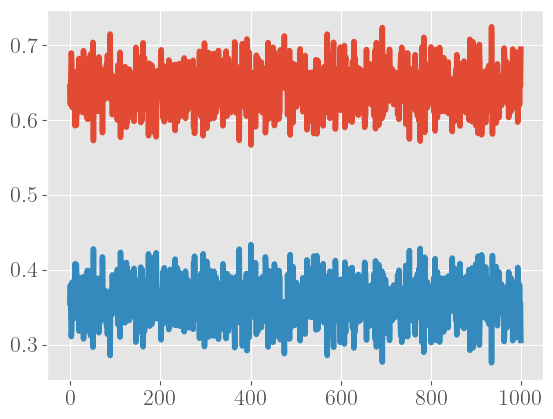

In [505]:
gs.weights.mean(axis=0)
plt.plot(gs.weights)

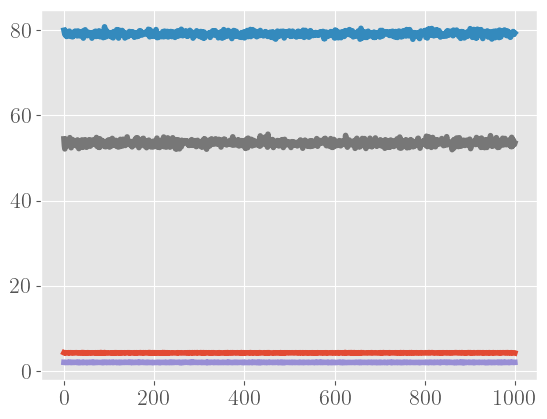

In [506]:
plt.plot(gs.means[:, 0])
plt.plot(gs.means[:, 1])

In [507]:
gs.weights.mean(axis=0)

array([0.64314141, 0.35685859])

In [508]:
np.array(gs.covs).mean(axis=0)

array([[[ 0.16982046,  0.93871793],
        [ 0.93871793, 36.02497019]],

       [[ 0.06927449,  0.43627723],
        [ 0.43627723, 33.70493352]]])

(-1.0, 5.0)

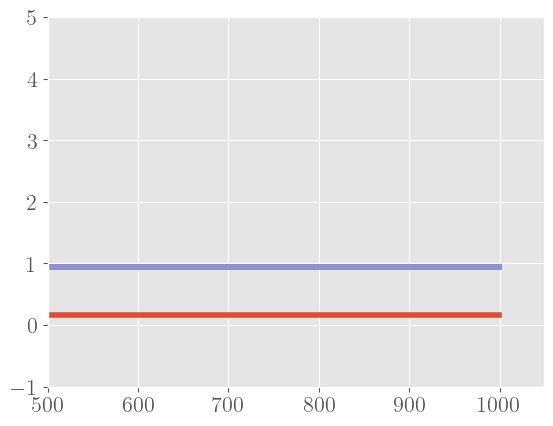

In [509]:
plt.plot(np.array(gs.covs)[:, 0, 0, 0])
plt.plot(np.array(gs.covs)[:, 0, 0, 1])
plt.plot(np.array(gs.covs)[:, 0, 1, 0])
plt.plot(np.array(gs.covs)[:, 0, 1, 1])


plt.xlim(left=500)
plt.ylim(-1, 5)

(-1.0, 5.0)

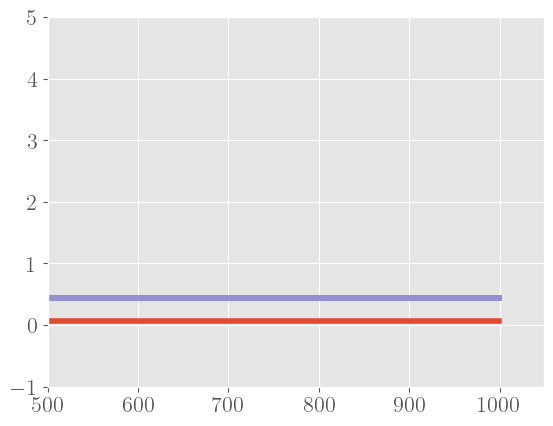

In [510]:
plt.plot(np.array(gs.covs)[:, 1, 0, 0])
plt.plot(np.array(gs.covs)[:, 1, 0, 1])
plt.plot(np.array(gs.covs)[:, 1, 1, 0])
plt.plot(np.array(gs.covs)[:, 1, 1, 1])
plt.xlim(left=500)
plt.ylim(-1, 5)